<a href="https://colab.research.google.com/github/santiric/reasoning_on_svm/blob/main/reasoning_on_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Riccardo Santi* - 2182525 - *Scienze Statistiche*

## Why margin maximization can be problematic in medical diagnosis (or other cases where we are much more worried to correcly classify one class rather than the other ones)

Support Vector Machines (SVMs) are a powerful family of classifiers. In their classic form, SVMs learn a decision boundary by maximizing the margin between classes while penalizing misclassifications through a uniform slack penalty.

This objective is elegant and often leads to robust classification boundaries. However, it embodies assumptions that may be inappropriate for **cost-sensitive decision problems**, such as medical diagnosis, where different types of errors have dramatically different real-world consequences.


---



## Margin-oriented objective vs. asymmetric costs

The SVM objective treats false positives (FP) and false negatives (FN) symmetrically unless explicitly modified.

In medical diagnosis, this symmetry is usually undesirable. A false negative (missing a disease) may lead to delayed treatment or death, whereas a false positive typically leads to additional tests or monitoring.

In such contexts, we often prefer classifiers that **prioritize sensitivity (true positive rate)**, even at the cost of increased false positives.

---

## Calibration, probabilities, and decision constraints

Many diagnostic workflows rely on probabilistic risk scores and decision thresholds chosen to satisfy clinical constraints (e.g., sensitivity ≥ 95%).

Logistic regression directly estimates probabilities of disease, which makes threshold tuning straightforward and interpretable. In contrast, standard SVMs do not produce well-calibrated probabilities. While post-hoc calibration methods exist, they add complexity and do not fundamentally change the margin-based objective.

Moreover, SVMs do not naturally allow practitioners to impose explicit constraints such as a bound on the false negative rate.

---


## Simulation study

We now illustrate these ideas with a small Monte Carlo simulation.

We simulate a binary disease outcome that depends on two continuous biomarkers. We compare:

- Logistic regression (probability-based, threshold-tunable)
- Linear SVM (margin-based)

The goal is to show that logistic regression allows us to explicitly choose a decision boundary that controls the false negative rate, whereas SVMs do not offer this flexibility naturally.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
# Helper functions
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

Let's assume this generative structure for the data:

In [ ]:
def generate_data(n=200, beta=(-2.0, 1.5, 1.0), random_state=None):
    """
    Generate synthetic diagnostic data.

    Parameters
    ----------
    n : int
        Number of patients
    beta : tuple
        (intercept, coefficient for x1, coefficient for x2)
    random_state : int or None
        Seed for reproducibility
    """
    rng = np.random.RandomState(random_state)

    # Two biomarkers (easy to plot later, just for that)
    x1 = rng.normal(size=n)
    x2 = rng.normal(size=n)

    # Latent disease risk
    linear_predictor = beta[0] + beta[1] * x1 + beta[2] * x2
    p_disease = sigmoid(linear_predictor)

    # Observed disease status
    y = rng.binomial(1, p_disease)

    X = np.column_stack((x1, x2))
    return X, y, p_disease


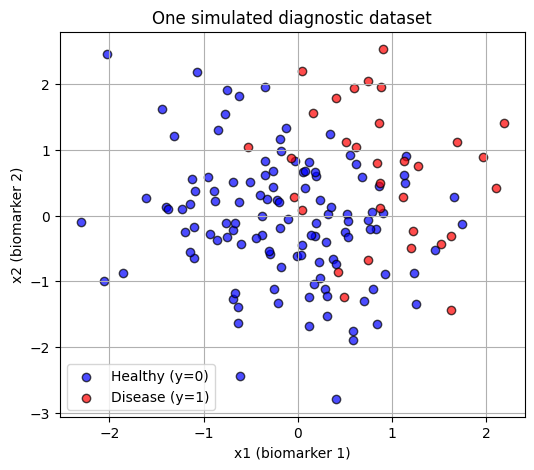

In [ ]:
# Generate one example dataset
X, y, p = generate_data(n=150, random_state=1)
plt.figure(figsize=(6, 5))

plt.scatter(X[y == 0, 0], X[y == 0, 1],
            c='blue', edgecolor='k', alpha=0.7, label='Healthy (y=0)')

plt.scatter(X[y == 1, 0], X[y == 1, 1],
            c='red', edgecolor='k', alpha=0.7, label='Disease (y=1)')

plt.xlabel('x1 (biomarker 1)')
plt.ylabel('x2 (biomarker 2)')
plt.title('One simulated diagnostic dataset')
plt.legend()
plt.grid(True)
plt.show()

Let's import some libraries.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


Now let's fit a simple logistic regression.

In [ ]:
logit = LogisticRegression(solver='lbfgs')
logit.fit(X, y)


LogisticRegression()

And a SVM:

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X, y)


SVC(kernel='linear')

Now let's take a look to decision boundaries:

In [ ]:
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x1_min, x1_max, 300),
    np.linspace(x2_min, x2_max, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]


In [ ]:
# desase probability
logit_probs = logit.predict_proba(grid)[:, 1]

# standard threshold p >= 0.5
logit_pred = (logit_probs >= 0.5).astype(int)
logit_pred = logit_pred.reshape(xx.shape)


In [ ]:
svm_pred = svm.predict(grid)
svm_pred = svm_pred.reshape(xx.shape)


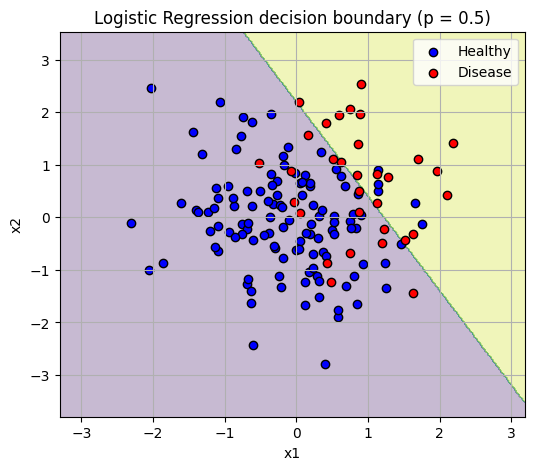

In [ ]:
plt.figure(figsize=(6, 5))

plt.contourf(xx, yy, logit_pred, alpha=0.3)
plt.scatter(X[y==0,0], X[y==0,1], c='blue', edgecolor='k', label='Healthy')
plt.scatter(X[y==1,0], X[y==1,1], c='red', edgecolor='k', label='Disease')

plt.title('Logistic Regression decision boundary (p = 0.5)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()


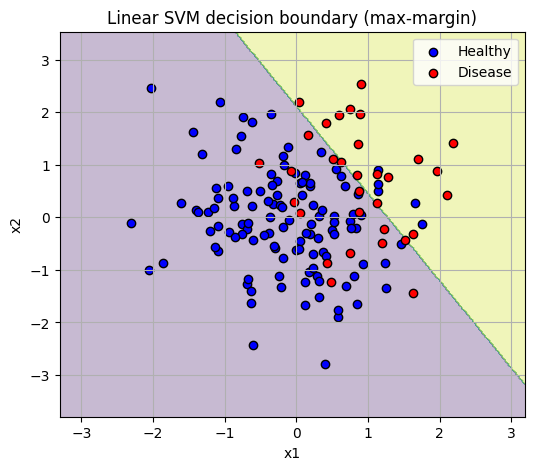

In [ ]:
plt.figure(figsize=(6, 5))

plt.contourf(xx, yy, svm_pred, alpha=0.3)
plt.scatter(X[y==0,0], X[y==0,1], c='blue', edgecolor='k', label='Healthy')
plt.scatter(X[y==1,0], X[y==1,1], c='red', edgecolor='k', label='Disease')

plt.title('Linear SVM decision boundary (max-margin)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()


The two methods gives similar results if we consider the standard threshold for the logistic model.

But the key point is that logistic regression give us an estimation of probabilities, and we can adjust the threshold to be more conservative. Actually, we could cross validate the threshold, but we are intersted in the general idea.

In [ ]:
logit_probs_data = logit.predict_proba(X)[:, 1]

probs_diseased = logit_probs_data[y == 1]

# Conservative threshold:
tau = 0.1

logit_pred_conservative = (logit_probs_data >= tau).astype(int)

In [ ]:
# False Negative Rate
fnr = np.mean((logit_pred_conservative == 0) & (y == 1))
fnr #very low (1-TPR)


np.float64(0.013333333333333334)

Of course, we obtain a higher sensitivity at the cost of a much lower specificity:

In [ ]:
#specificity:
tnr = np.mean((logit_pred_conservative == 0) & (y == 0))
tnr

np.float64(0.48)

Let's visualize it:

In [ ]:
logit_probs_grid = logit.predict_proba(grid)[:, 1]
logit_pred_grid_conservative = (logit_probs_grid >= tau).astype(int)
logit_pred_grid_conservative = logit_pred_grid_conservative.reshape(xx.shape)


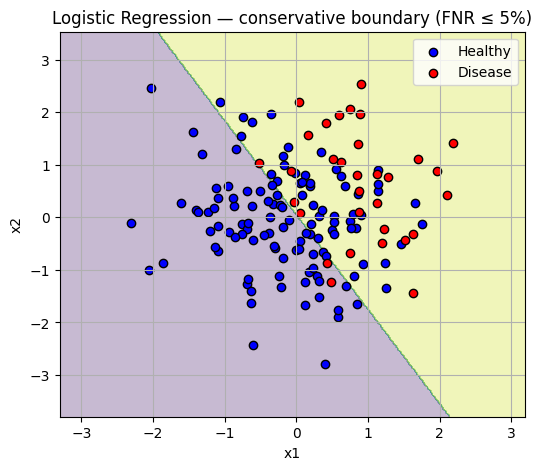

In [ ]:
plt.figure(figsize=(6, 5))

plt.contourf(xx, yy, logit_pred_grid_conservative, alpha=0.3)
plt.scatter(X[y==0,0], X[y==0,1], c='blue', edgecolor='k', label='Healthy')
plt.scatter(X[y==1,0], X[y==1,1], c='red', edgecolor='k', label='Disease')

plt.title(f'Logistic Regression — conservative boundary')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()


In conclusion, optimizing the margin has little to no sense in these cases.

Ai was used to help create the code for the simple